In [1]:
from IPython import get_ipython
import time
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import statsmodels.api as sm
from sklearn import preprocessing 
import ema_workbench.em_framework.evaluators


import os
from dest_directories import gz_path, fig_path
from dicemodel.specs import change_fontsize
from dicemodel.noDICE_v7 import PyDICE
model_version = 'v7'

In [2]:
from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, CategoricalParameter, TimeSeriesOutcome, ScalarOutcome, ArrayOutcome, Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)
from ema_workbench import save_results, load_results
from ema_workbench.analysis import prim, cart
from ema_workbench.analysis import scenario_discovery_util as sdutil
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, parcoords

ema_logging.log_to_stderr(ema_logging.INFO)

model = PyDICE()
dice_sm = Model('dicesmEMA', function=model)

In [3]:


dice_sm.uncertainties = [
    RealParameter('tfp_gr',  0.07, 0.09),
    RealParameter('sigma_gr', -0.012, -0.008),
    RealParameter('pop_gr', 0.1, 0.15),
    RealParameter('fosslim',  4000.0, 13649),
    IntegerParameter('cback', 100, 600),
     RealParameter('emdd', -1.0, 0.99),
    IntegerParameter('vd_switch', 0, 1),
    ]
# dice_sm.constants = [
    # Constant('emdd', 0.55),
    # Constant('vd_switch', 1)
    # ]
    
dice_sm.levers = [
    RealParameter('sr', 0.1, 0.5),
    RealParameter('prtp_con',  0.001, 0.015),
    RealParameter('emuc', 1.01, 2.00),
    IntegerParameter('periodfullpart', 10, 58),
    IntegerParameter('miu_period', 10, 58)
                 ]

dice_sm.outcomes = [
    TimeSeriesOutcome('Atmospheric Temperature'),
    TimeSeriesOutcome('Total Output'),
    TimeSeriesOutcome('Per Capita Consumption'),
    TimeSeriesOutcome('Consumption Growth'),
    TimeSeriesOutcome('Utility of Consumption'),
    TimeSeriesOutcome('Per Capita Damage'),
    TimeSeriesOutcome('Damage Growth'),
    TimeSeriesOutcome('Disutility of Damage'),
    TimeSeriesOutcome('Welfare'),
    # TimeSeriesOutcome('Undiscounted Period Welfare'),
    TimeSeriesOutcome('Consumption SDR'),
    TimeSeriesOutcome('Damage SDR'),
    TimeSeriesOutcome('SCC')
                    ]
# dice_sm.outcomes = [
#             ScalarOutcome('Atmospheric Temperature 2300', kind=ScalarOutcome.MINIMIZE),
#             ScalarOutcome('Total Output 2300', kind=ScalarOutcome.MAXIMIZE),
#             # ScalarOutcome('Per Capita Consumption 2300', kind=ScalarOutcome.INFO),
#             # ScalarOutcome('Consumption Growth 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Utility of Consumption 2300', kind=ScalarOutcome.MAXIMIZE),
#             # ScalarOutcome('Per Capita Damage 2300', kind=ScalarOutcome.INFO),
#             # ScalarOutcome('Damage Growth 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Disutility of Damage 2300', kind=ScalarOutcome.MINIMIZE),
#             ScalarOutcome('Welfare 2300', kind=ScalarOutcome.MAXIMIZE),
#             # ScalarOutcome('Undiscounted Period Welfare 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Consumption SDR 2300', kind=ScalarOutcome.INFO),
#             ScalarOutcome('Damage SDR 2300', kind=ScalarOutcome.INFO)
            # ]



In [4]:
dice_opt = pd.read_excel("DICE2013R.xlsm" ,sheet_name = "Opttax", index_col = 0)



In [5]:
from dicemodel.specs import nordhaus_policy, reference_scenario, change_fontsize


In [6]:
nord_optimal_policy = Policy('nord_optimal_policy', **nordhaus_policy(np.mean(dice_opt.iloc[129]),prtp_con =0.015,emuc=1.45, miu_period= 29, periodfullpart=29 )) # ,vd_switch=1  
nord_optimal_policy



Policy({'sr': 0.24868248835166676, 'prtp con': 0.015, 'emuc': 1.45, 'periodfullpart': 29, 'miu_period': 29})

In [7]:
n_scenarios = 100000
run = 'run_42_NordOE_'

# 32: OE with corrected emdd range
# 33: vd_switch back in the uncertainties. We will have both outcomes for comparison with Nordhaus policy ----- very weird results. No effect of vd switch at all. showing much higher values for SCC, much lower for temp, V(D) either 0 or 1??
# 34: retry
# 35: miu_period corrected to 29, from 0.
# 39: Nord OE with 
# 40: Nord OE with SCC correctly initialized
# 41: no run changes, re-saving model changes and repeating run because init SCC remains negative in run 40
# 42: vd_switch and EMDD removed from mdoel constants to uncertainties



In [8]:

start = time.time()
with MultiprocessingEvaluator(dice_sm, n_processes=16) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies= nord_optimal_policy)
end = time.time()

print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100000 scenarios * 1 policies * 1 model(s) = 100000 experiments
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 30000 cases completed
[MainProcess/INFO] 40000 cases completed
[MainProcess/INFO] 50000 cases completed
[MainProcess/INFO] 60000 cases completed
[MainProcess/INFO] 70000 cases completed
[MainProcess/INFO] 80000 cases completed
[MainProcess/INFO] 90000 cases completed
[MainProcess/INFO] 100000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
Experiment time is 2 mintues


In [9]:
results = experiments, outcomes

start = time.time()
save_results(results, os.path.join(gz_path, str(run) + str(n_scenarios) + 's_' + '.tar.gz'))
end = time.time()

print('Saving time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] results saved successfully to E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\run_42_NordOE_100000s_.tar.gz
Saving time is 5 mintues


In [10]:
# results = load_results(os.path.join(gz_path,'run_39_NordOE_100000s_.tar.gz'))
# experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from E:\Year_2_Quarter_4\Thesis\06_Code\results\gz_files\run_39_NordOE_100000s_.tar.gz


In [11]:
cleaned_outcome = {}

In [12]:
for key, value in outcomes.items():
    cleaned_outcome[key] = value[:,2:-5]  
cleaned_outcome['Welfare'].shape


(100000, 58)

# pairs 1 = output, temp, damages, consumption, W
# pairs 2 = temp, U(C), V(D), W 
# pairs 3 = Con, con_g, sdr_con, U(C)
# pairs 4 = damages, sdr_dam, V(D) 
# time = temp, U(C), V(D), W, 
# time 2 = con, dam, sdr_con, sdr_dam

In [16]:
import copy

outcomes_shown = 'pairs_2'
cleaned_outcome_pairs_2 ={}
cleaned_outcome_pairs_2 = copy.deepcopy(cleaned_outcome)
# outcomes

In [17]:
# remove outcomes that you dont need for pairs plots and time series
rem_list = [
    # 'Atmospheric Temperature',
    'Total Output',
    'Per Capita Consumption',
    'Consumption Growth',
    # 'Utility of Consumption',
    'Per Capita Damage',
    'Damage Growth',
    # 'Disutility of Damage',
    # 'Welfare',
    'Consumption SDR',
    'Damage SDR',
    'SCC'
]
for key in rem_list:
    cleaned_outcome_pairs_2.pop(key)
    



In [19]:
cleaned_outcome_pairs_2.keys()



dict_keys(['Atmospheric Temperature', 'Utility of Consumption', 'Disutility of Damage', 'Welfare'])

In [22]:
# Values for 2300
end_outcome = {}
for key, value in cleaned_outcome_pairs_2.items():
    end_outcome[key] = value[:, -1] 

In [78]:
# # Values for 2150
# outcome_2150 = {}
# for key, value in cleaned_outcome_pairs_2.items():
#     outcome_2150[key] = value[:, 29]  
# outcome_2150['Welfare']
# # np.mean(cleaned_outcome['Damage Growth'], axis =0)


array([-3859.81323049, -3854.77446554, -3854.76994637, ...,
       -3854.76628057, -3854.76616565, -3854.7658886 ])

In [23]:
end_outcome.keys()

dict_keys(['Atmospheric Temperature', 'Utility of Consumption', 'Disutility of Damage', 'Welfare'])

In [37]:
grouping_specifiers_VD = {'without V(D)':0, 'with V(D)':1}
grouping_labels_VD = (grouping_specifiers_VD.keys())


In [50]:
# # Time series envelope outcome grouped by V(D) switch

# for outcome in cleaned_outcome.keys():
#     fig,axes=plotting.envelopes(experiments, cleaned_outcome, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, group_by='vd_switch', grouping_specifiers= grouping_specifiers_VD,legend=True)
    

#     fig.set_size_inches(25, 10)
#     change_fontsize(fig, fs=20)
#     # repeat_token = 2
#     fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_envelope_' + str(outcome) + '_x.png')) #  + '_repeat' +str(repeat_token) 
# plt.show()



## Pairs plots

In [25]:
out_DF = pd.DataFrame(end_outcome)
out_DF.head()
emdd = experiments['emdd']
out_DF['emdd'] = emdd

In [26]:
out_DF['emdd'] = out_DF['emdd'].apply(
    lambda x: '-1 to -0.5' if x < -0.5
        else('-0.5 to 0' if (x < 0)
            else('0 to 0.5' if (x < 0.5)
                else ('0.5 to 0.99')
                )
            )
    )

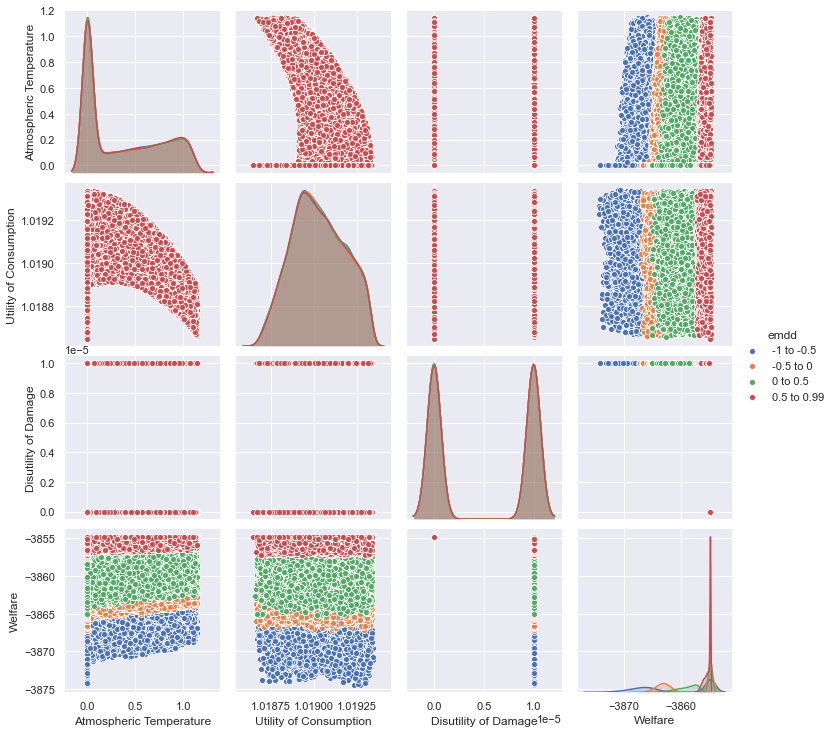

In [31]:
# repeat to compare with below, delete after
sns.set(style = "darkgrid")
sns_plot = sns.pairplot(out_DF, hue='emdd', hue_order=['-1 to -0.5', '-0.5 to 0', '0 to 0.5', '0.5 to 0.99'], vars=list(end_outcome.keys())) # palette=clr_palette
# fig = plt.gcf
# ax = plt.gca
# fig, ax = plt.pyplot.subplots()
# change_fontsize(fig, fs=20)
# fig.set_size_inches(20, 20)
plt.show()

In [32]:
sns_plot.savefig(os.path.join(fig_path, str(run) + '_sns_grouped_by_emdd' +str(outcomes_shown) +'.png'))

In [ ]:
# grouped  by V(D) switch

[MainProcess/INFO] no time dimension found in results


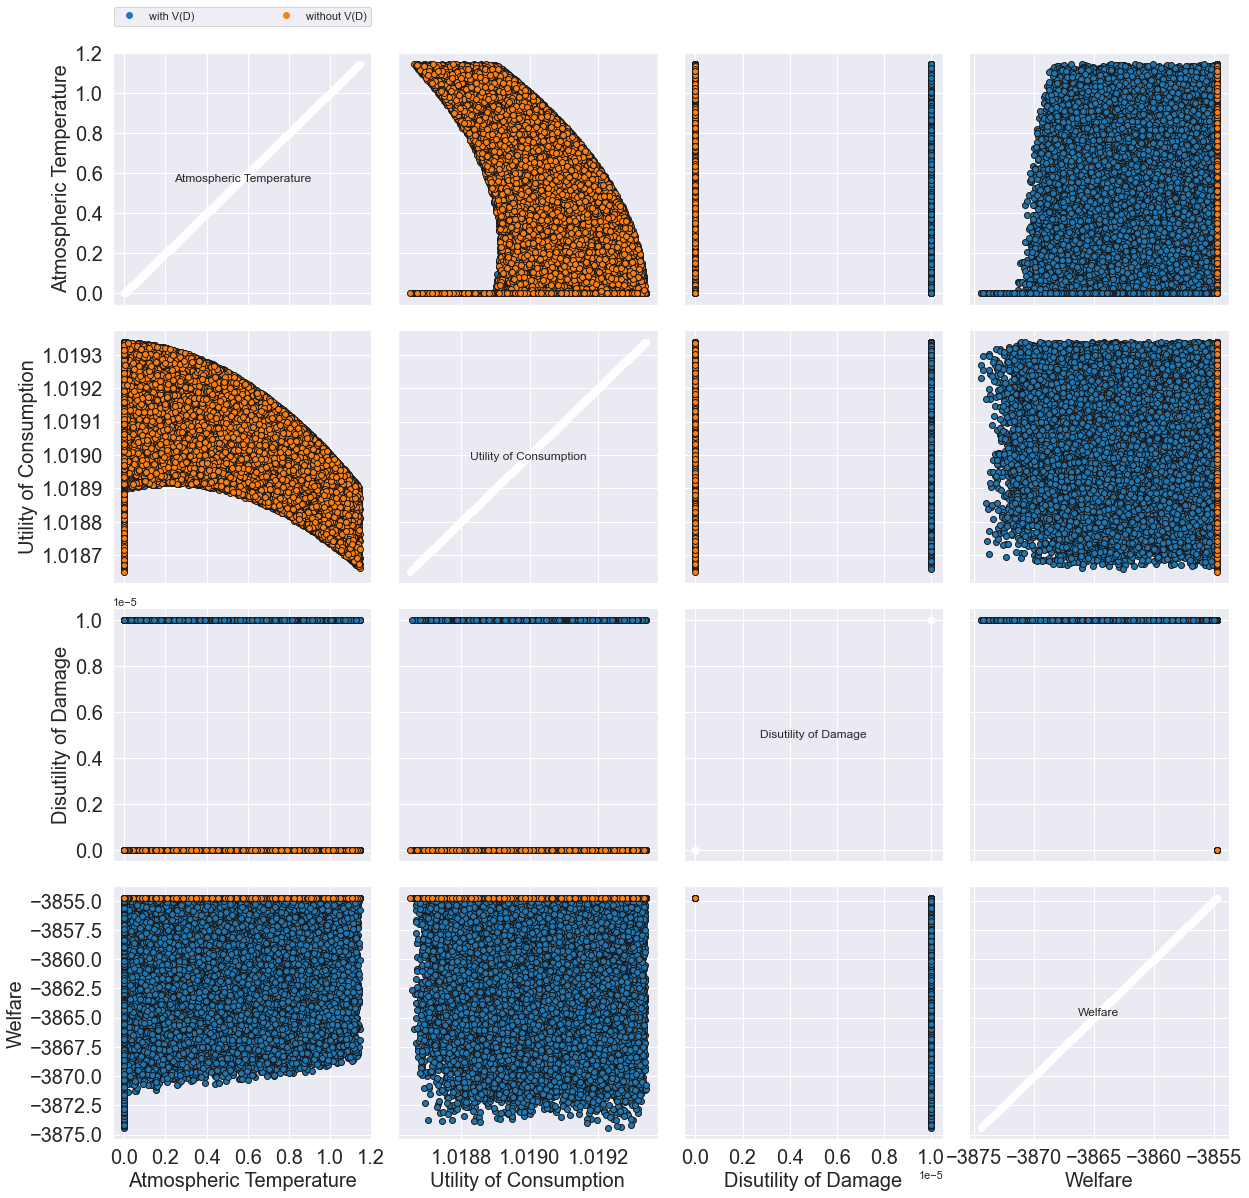

In [35]:
fig, axes = pairs_plotting.pairs_scatter(experiments,end_outcome, group_by='vd_switch',grouping_specifiers=grouping_specifiers_VD, legend=True, transparent=True) # point_in_time=29
fig.set_size_inches(20,20)
change_fontsize(fig, fs=20)
plt.show()

# repeat_token = 2 #  + str(repeat_token) 
# fig.savefig(os.path.join(fig_path, str(run) + 'grouped_V(D)switch_'+ str(outcomes_shown) +'.png')) 

In [36]:
np.max(end_outcome['Disutility of Damage'])

1e-05

In [69]:
np.max(end_outcome['Atmospheric Temperature'])

1.1488994192547362

In [ ]:
fig, axes = pairs_plotting.pairs_scatter(experiments,cleaned_outcome,legend=True, transparent=True)
fig.set_size_inches(20,20)
change_fontsize(fig, fs=20)
plt.show()

# repeat_token = 2 #  + str(repeat_token) 
fig.savefig(os.path.join(fig_path, str(run) + 'pairs2_grouped_V(D)switch_'+ 'tstep29.png')) 

## Time Series envelopes 

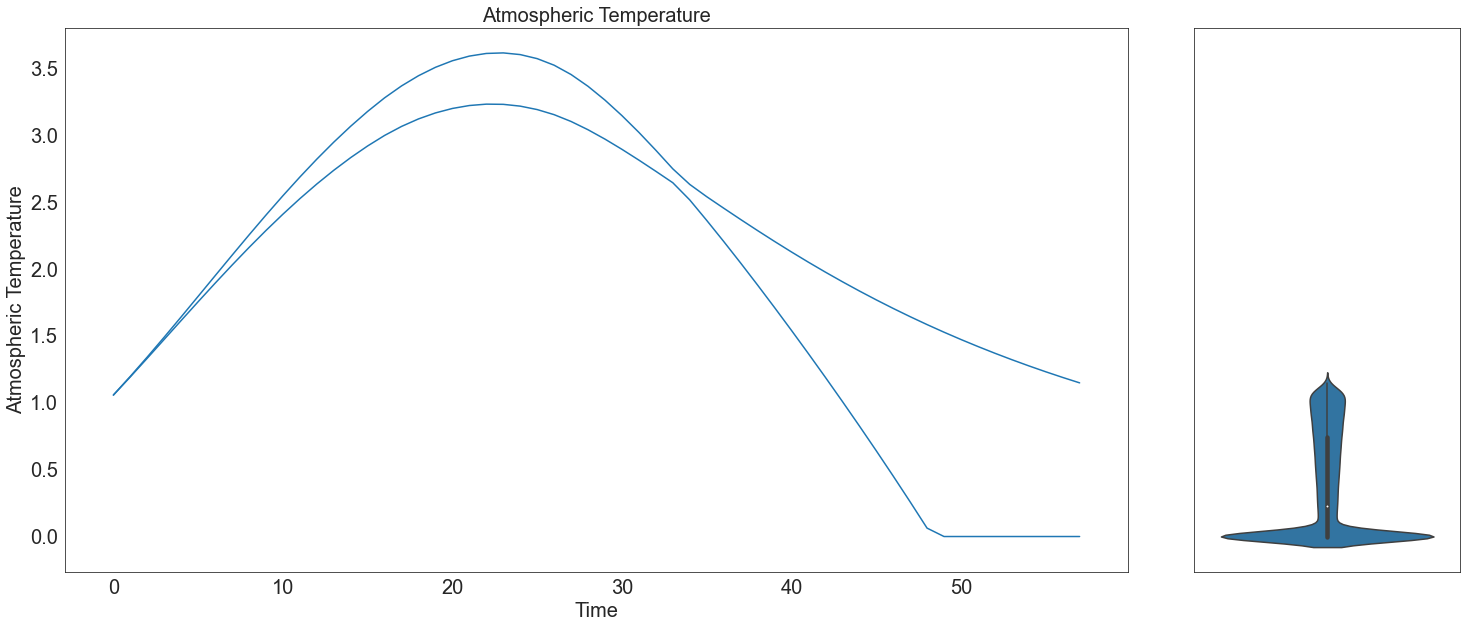

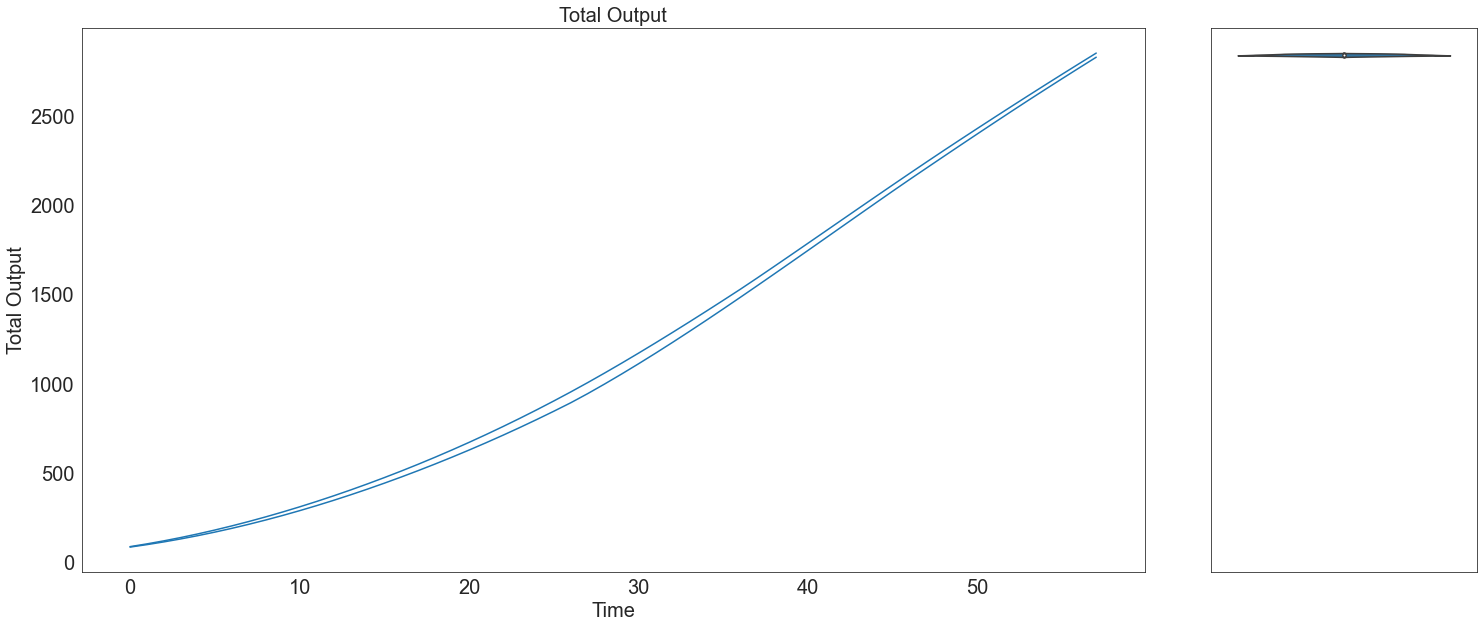

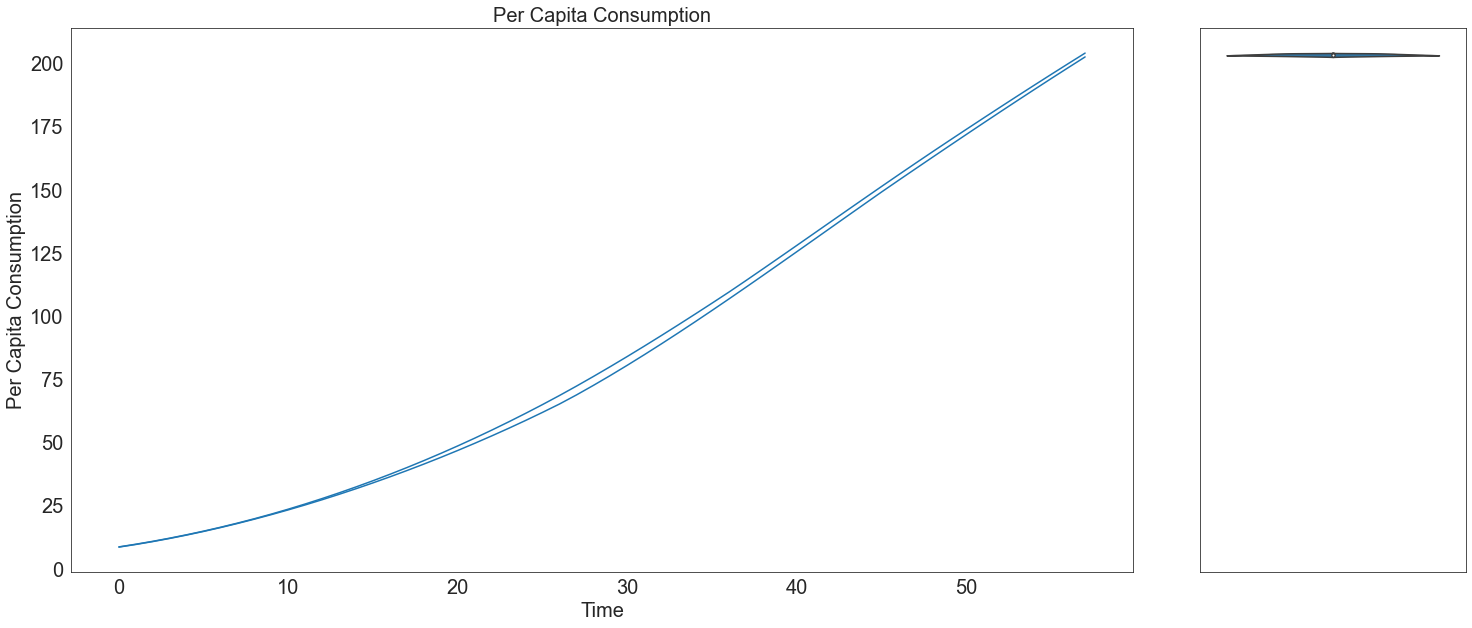

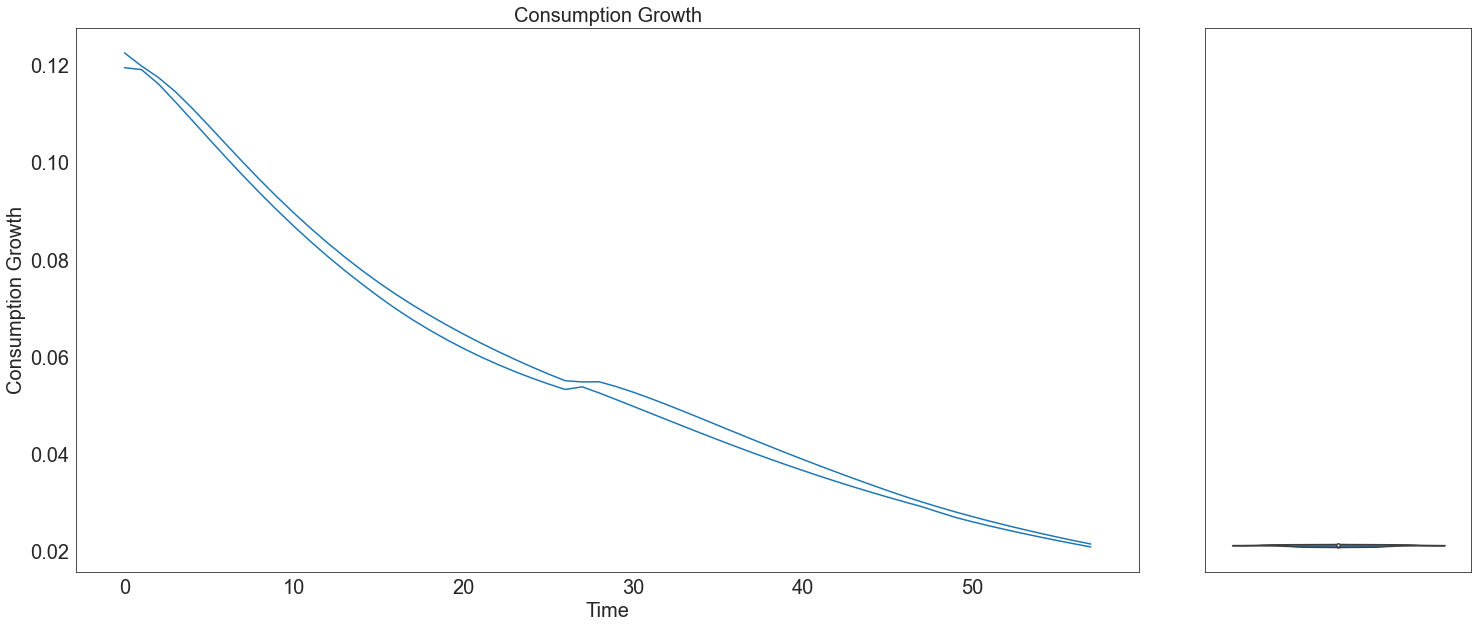

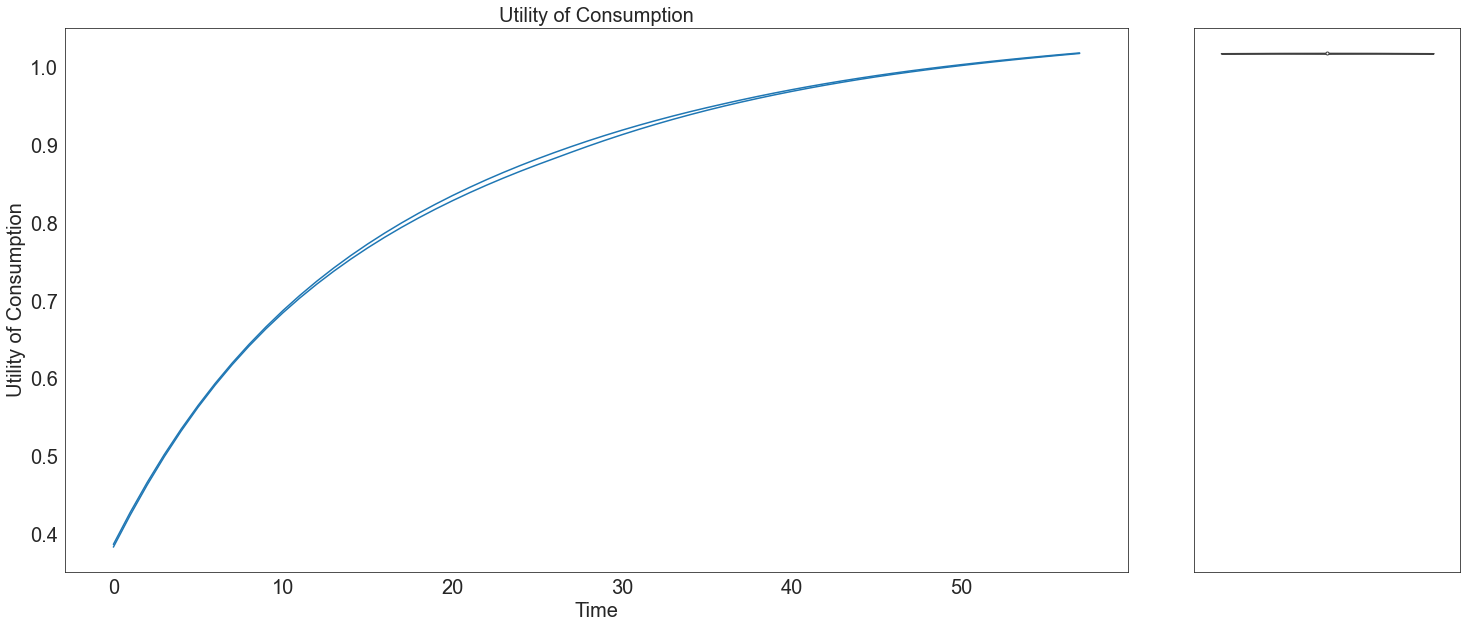

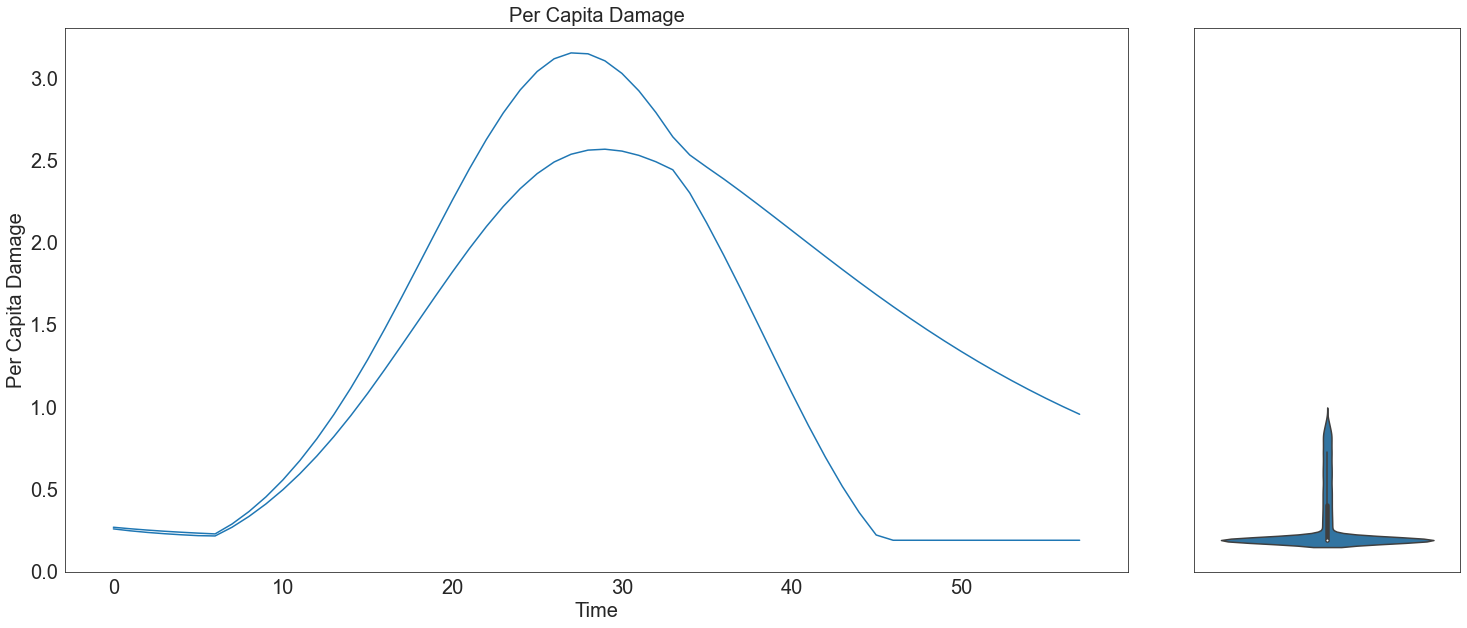

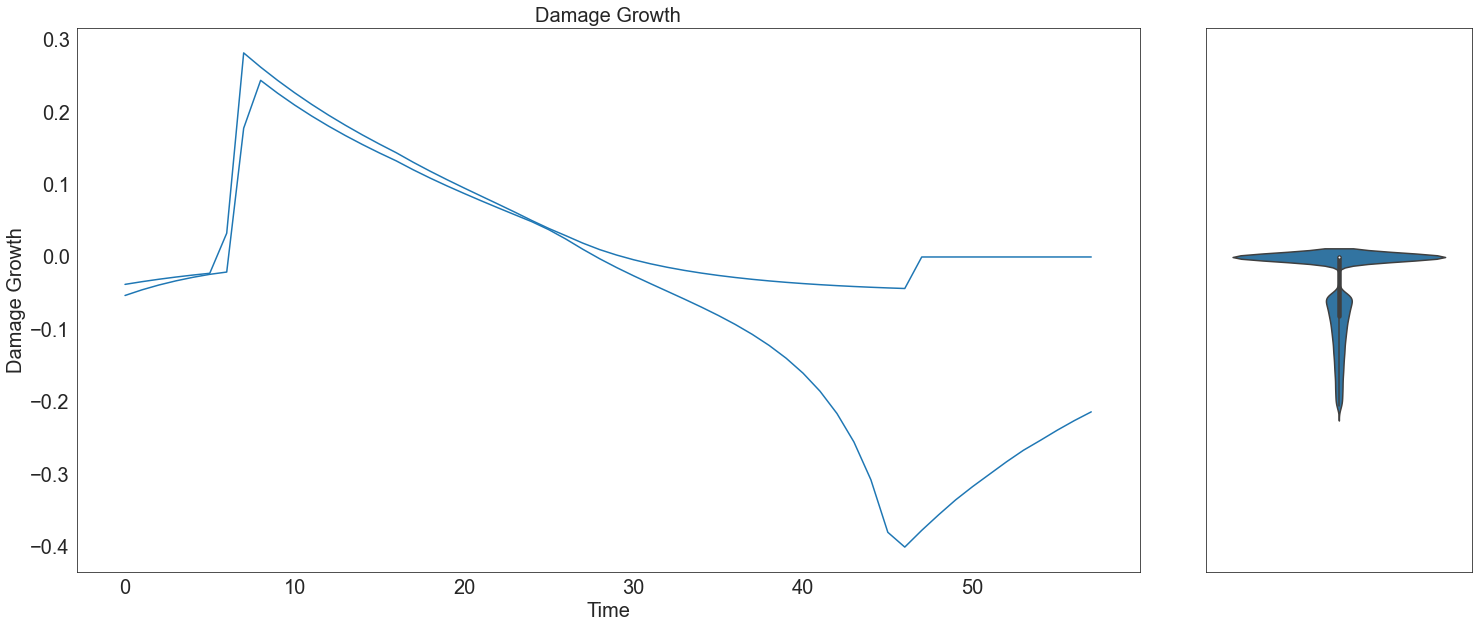

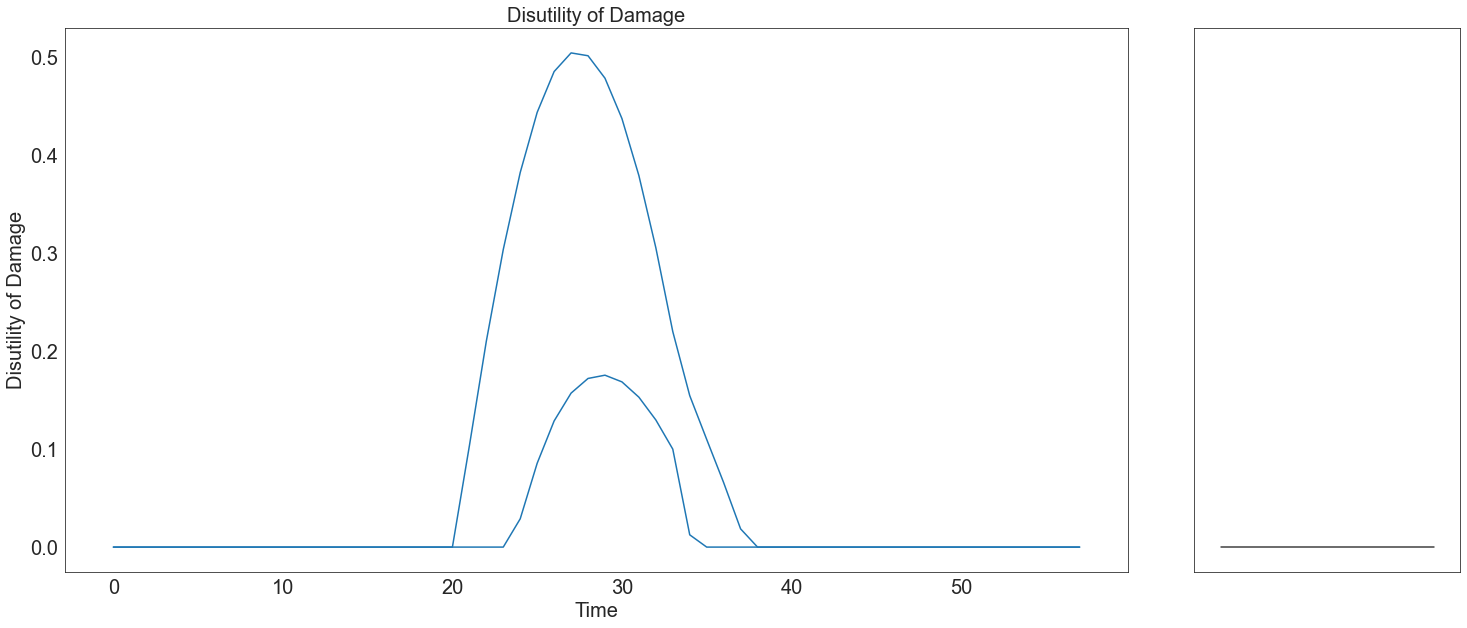

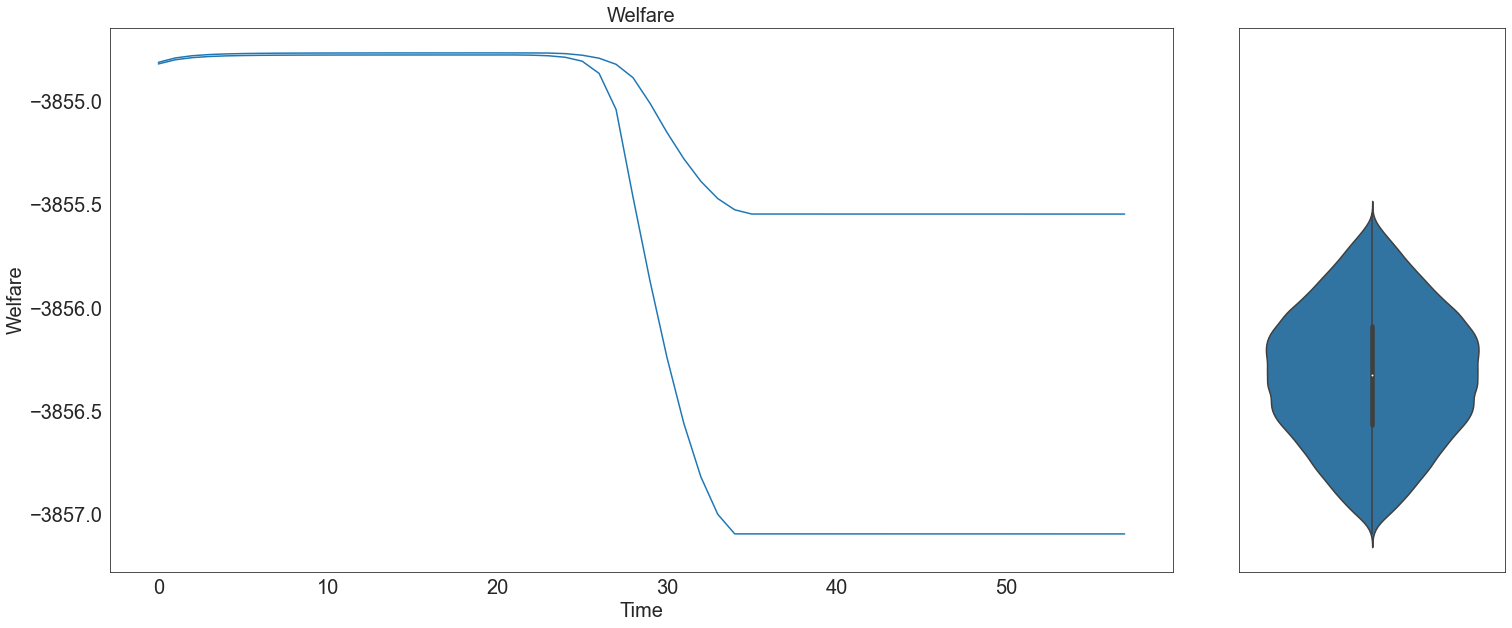

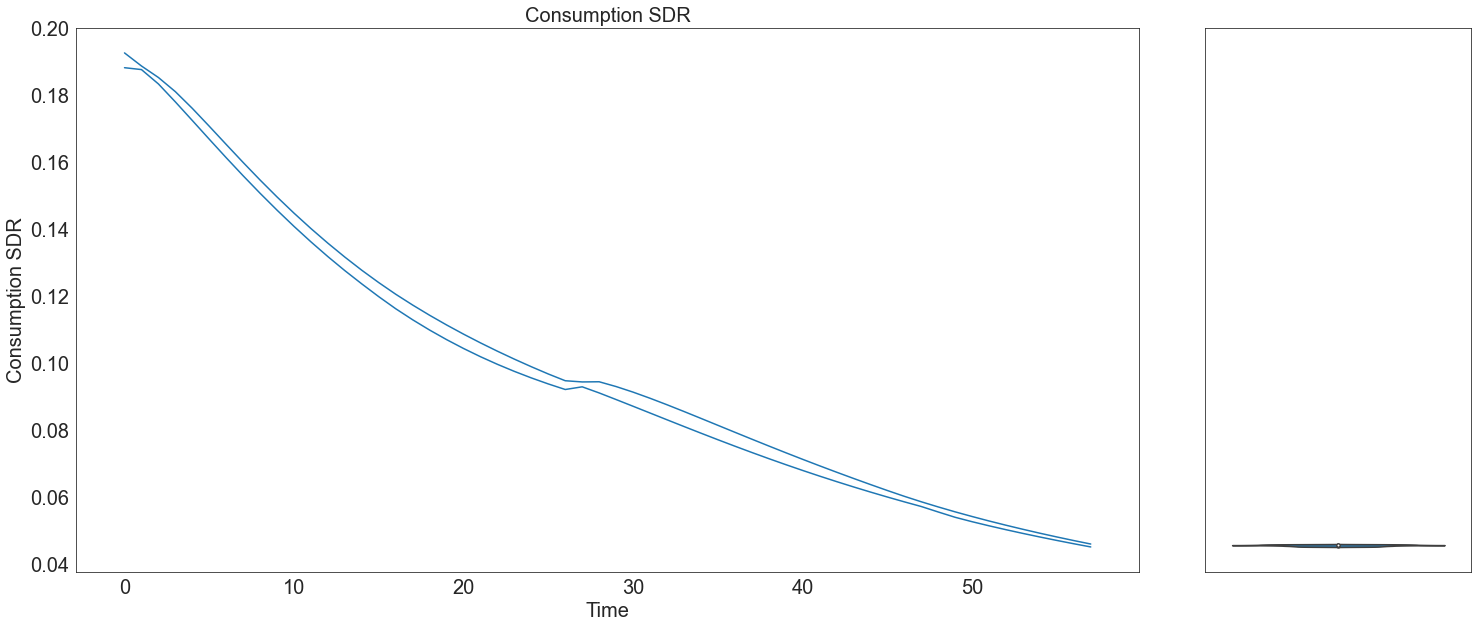

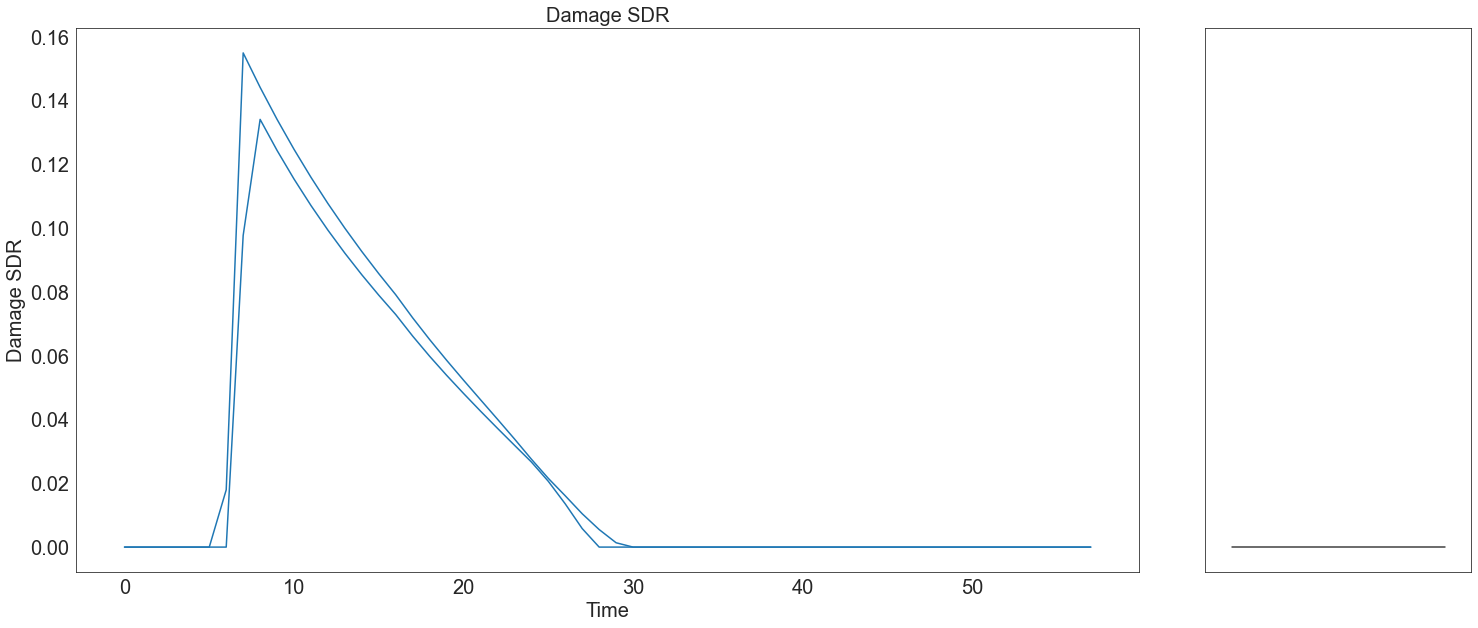

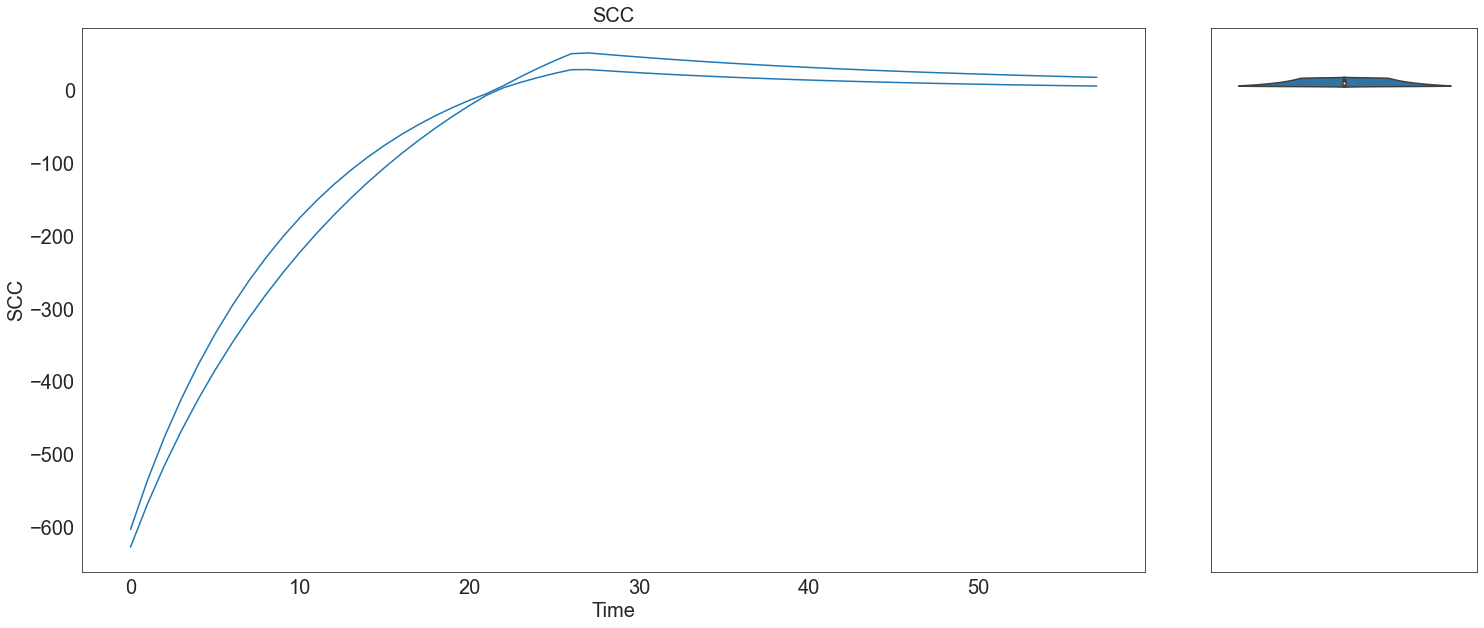

In [17]:
# [Run 41] Time series envelope outcome grouped by V(D) switch

for outcome in cleaned_outcome.keys():
    fig,axes=plotting.envelopes(experiments, cleaned_outcome,outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, legend=True)
    

    fig.set_size_inches(25, 10)
    change_fontsize(fig, fs=20)
    repeat_token = 1
    fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_envelope_' + str(outcome) + '.png'))
plt.show()


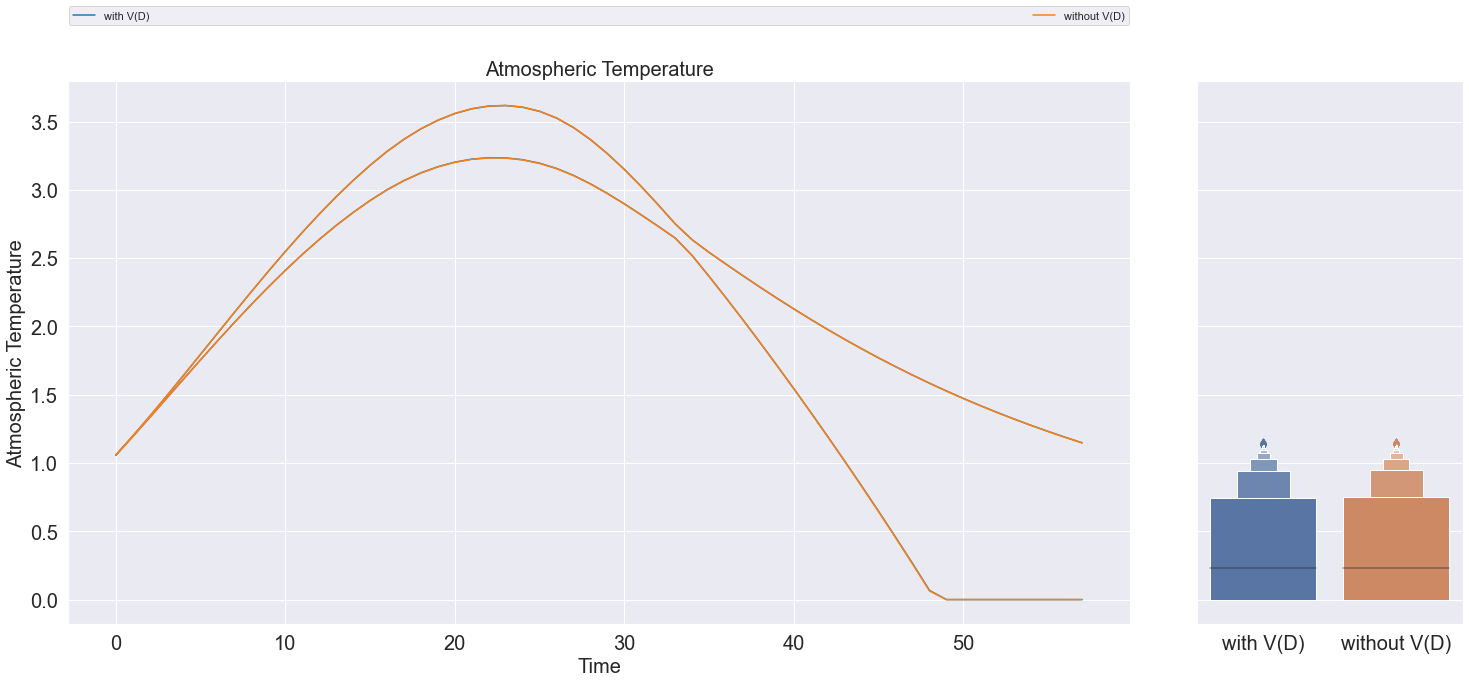

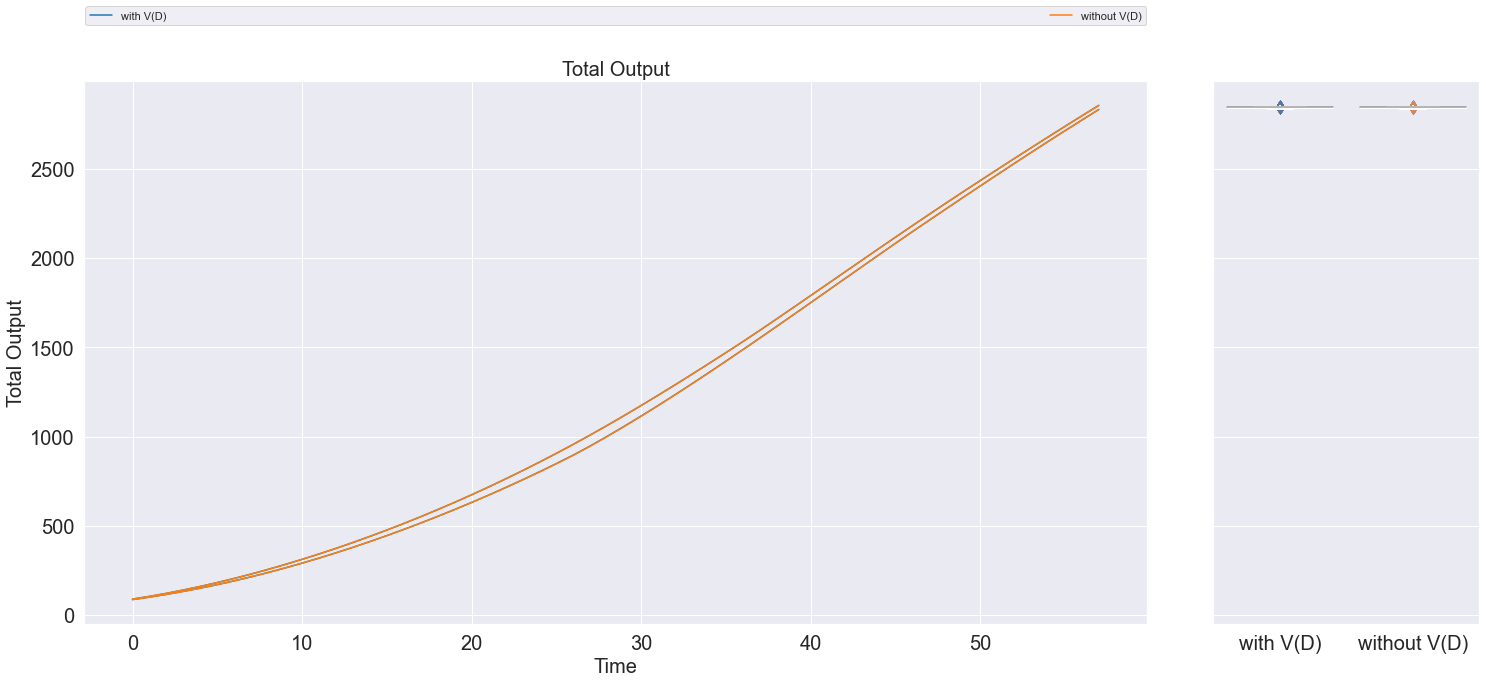

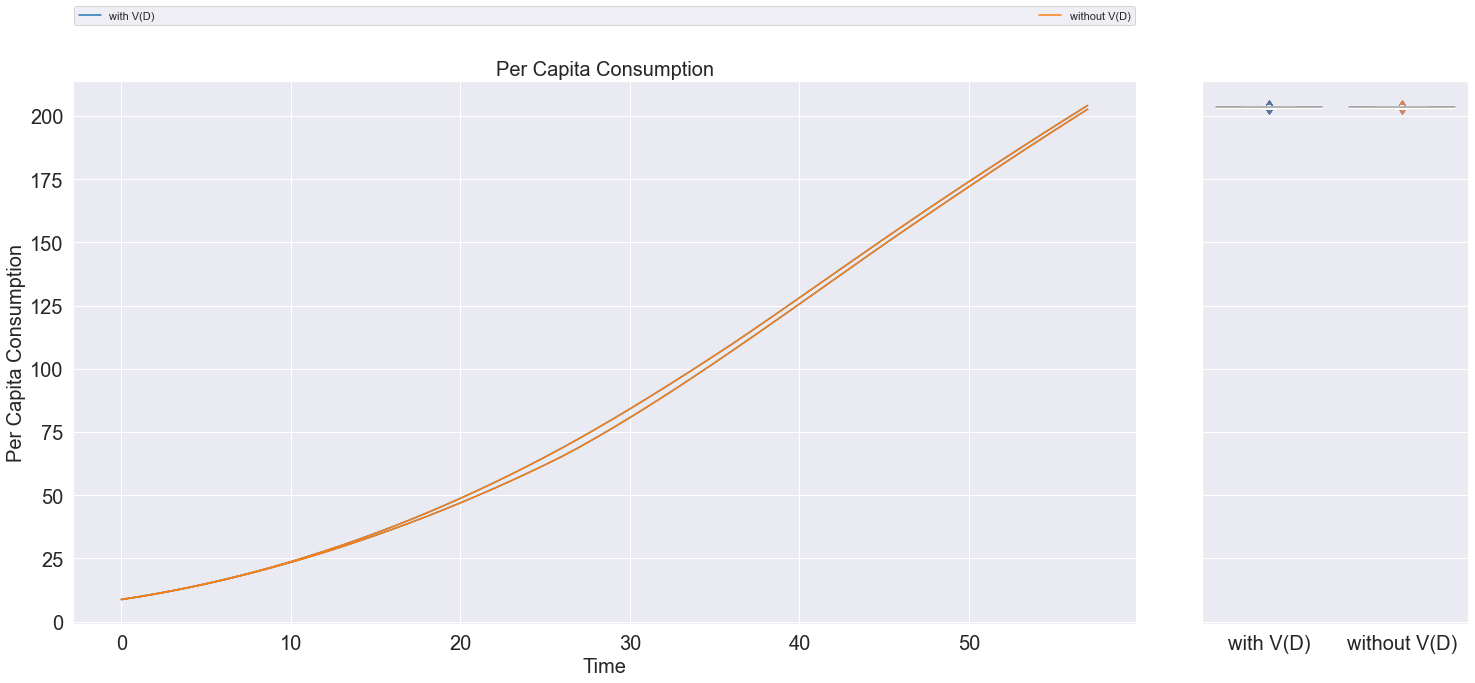

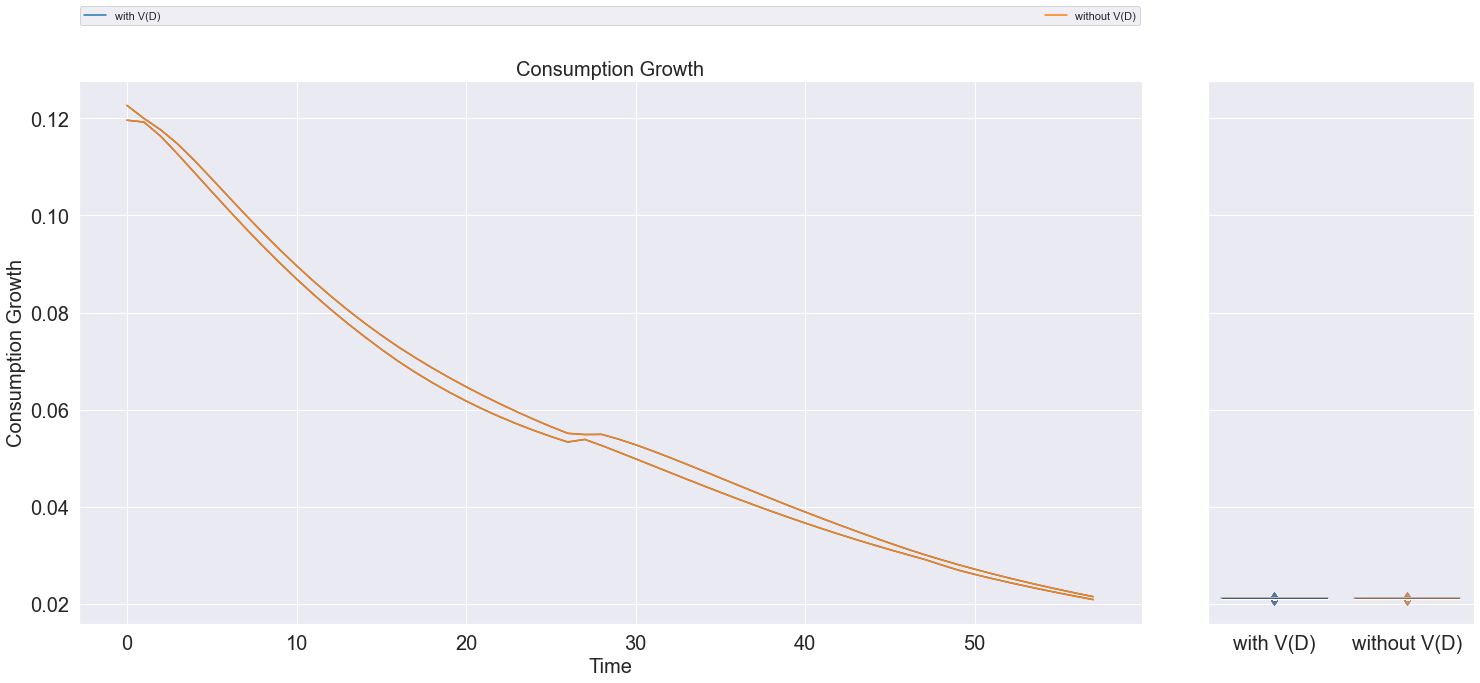

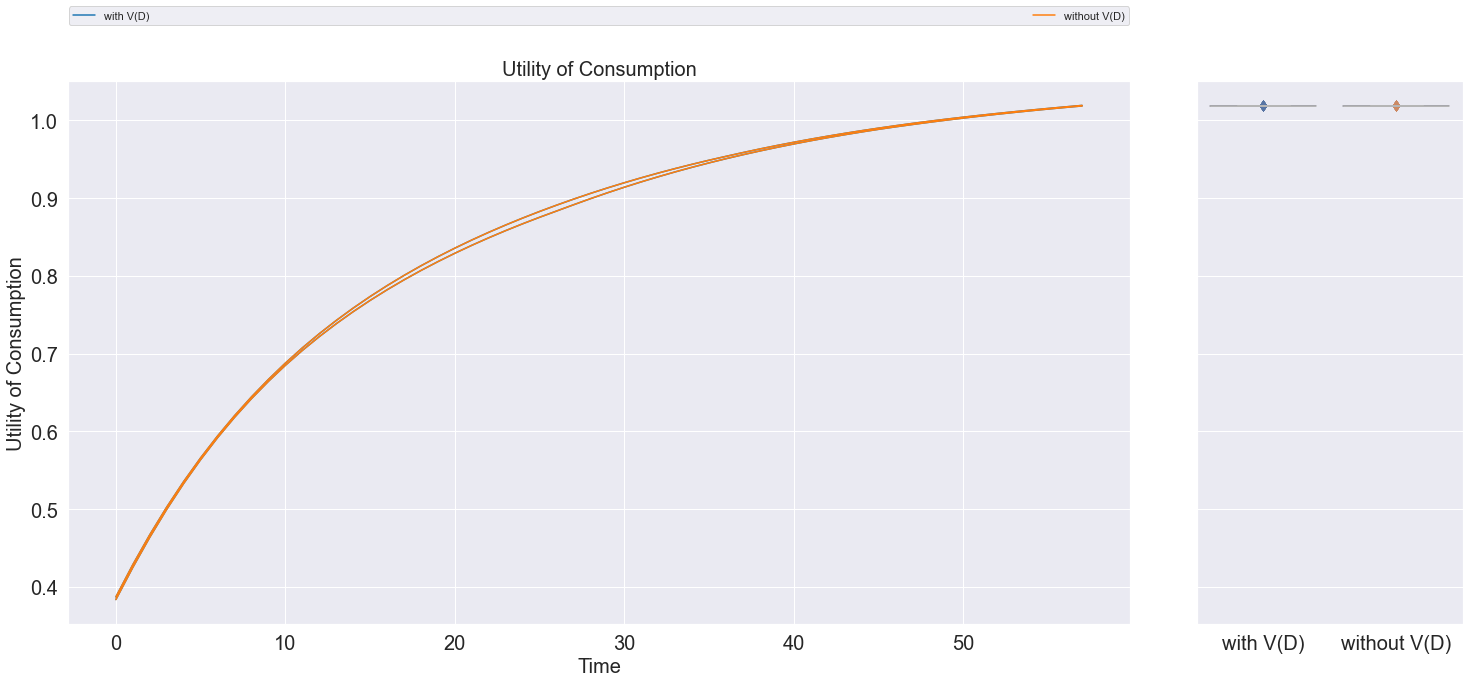

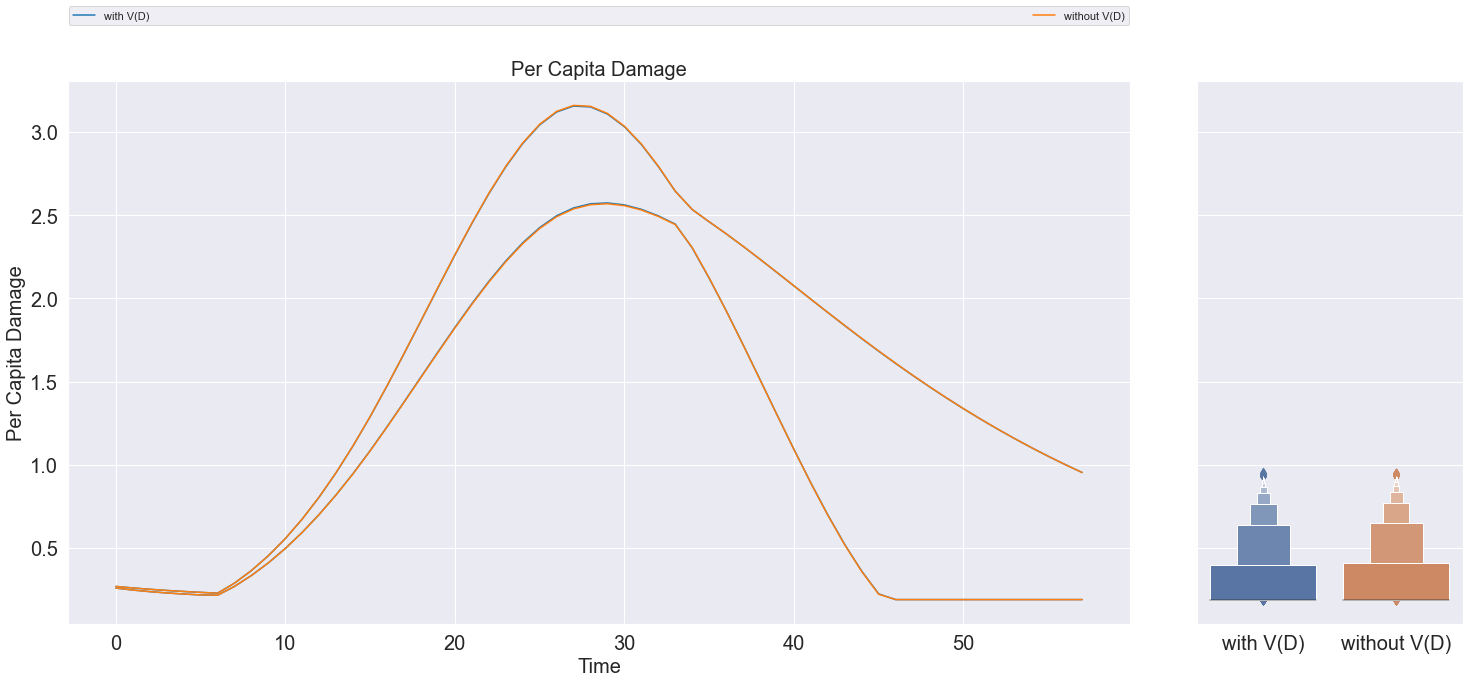

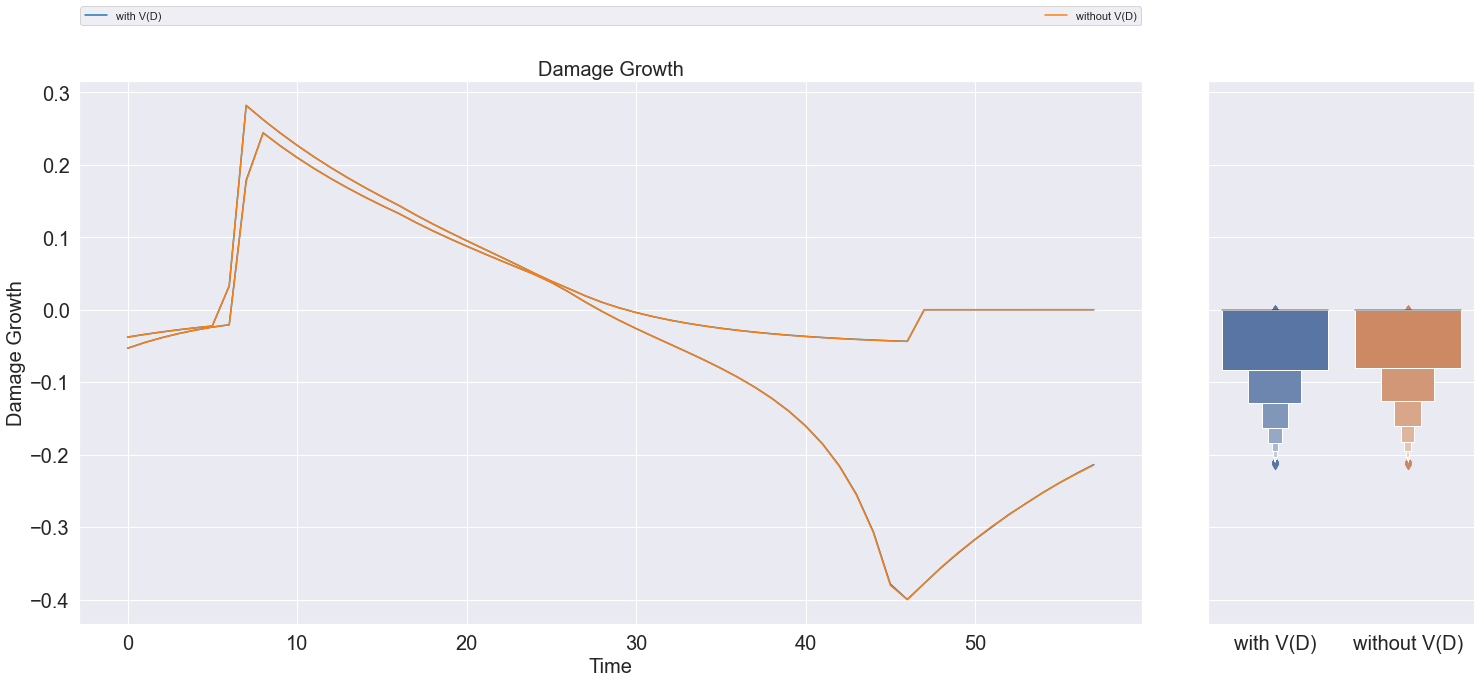

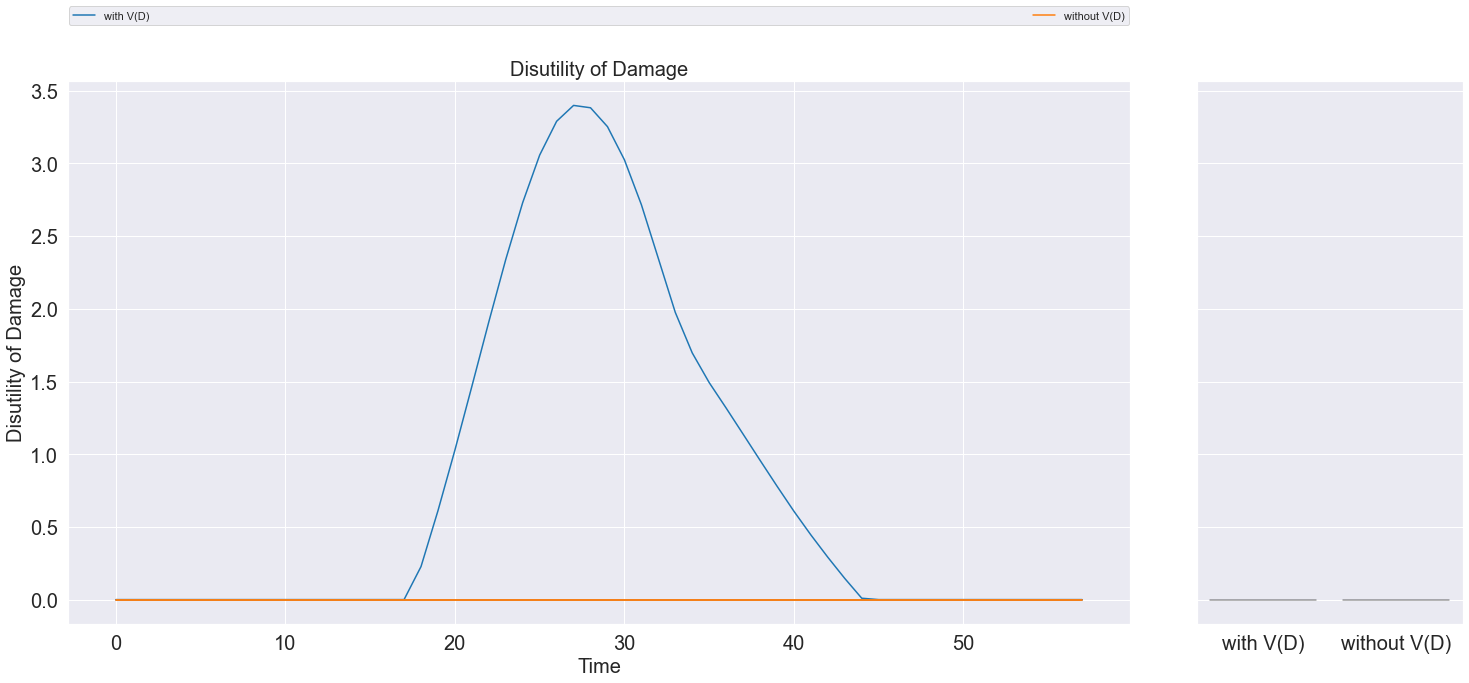

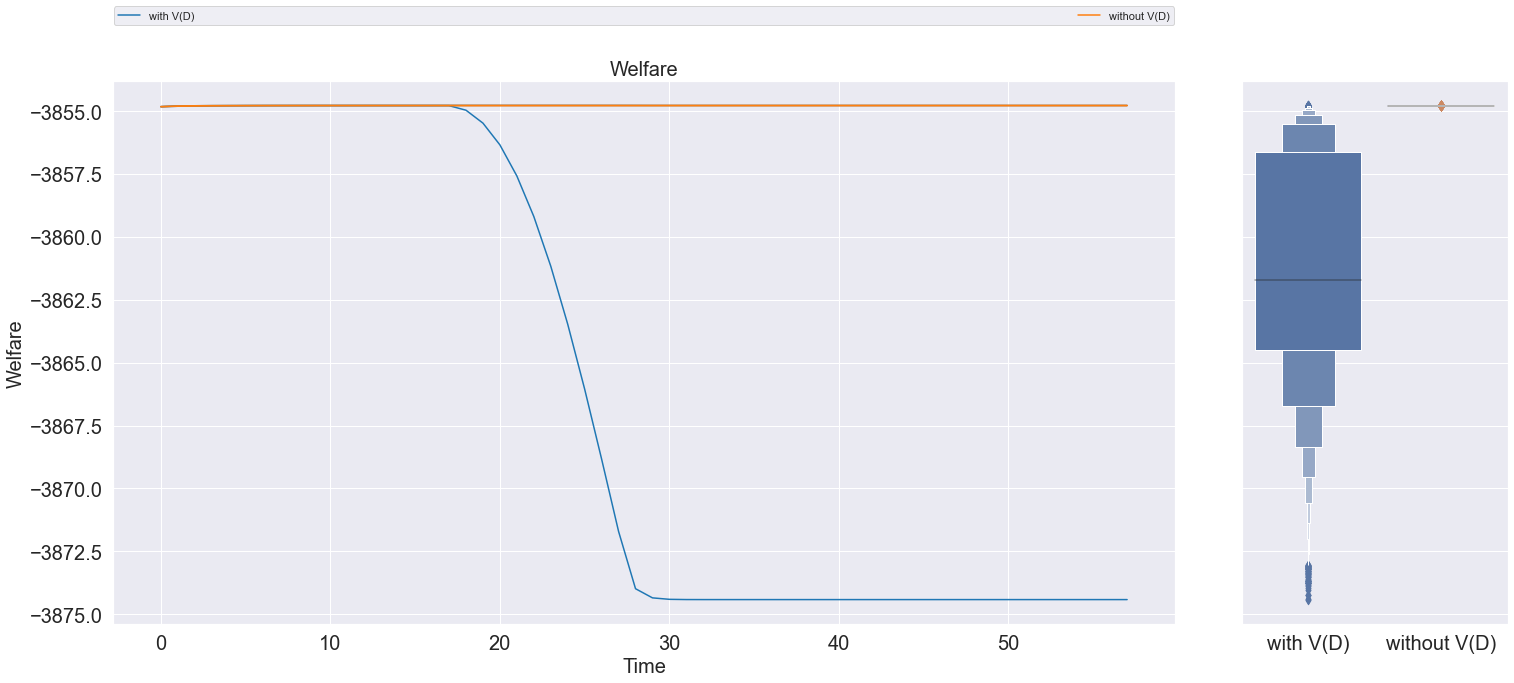

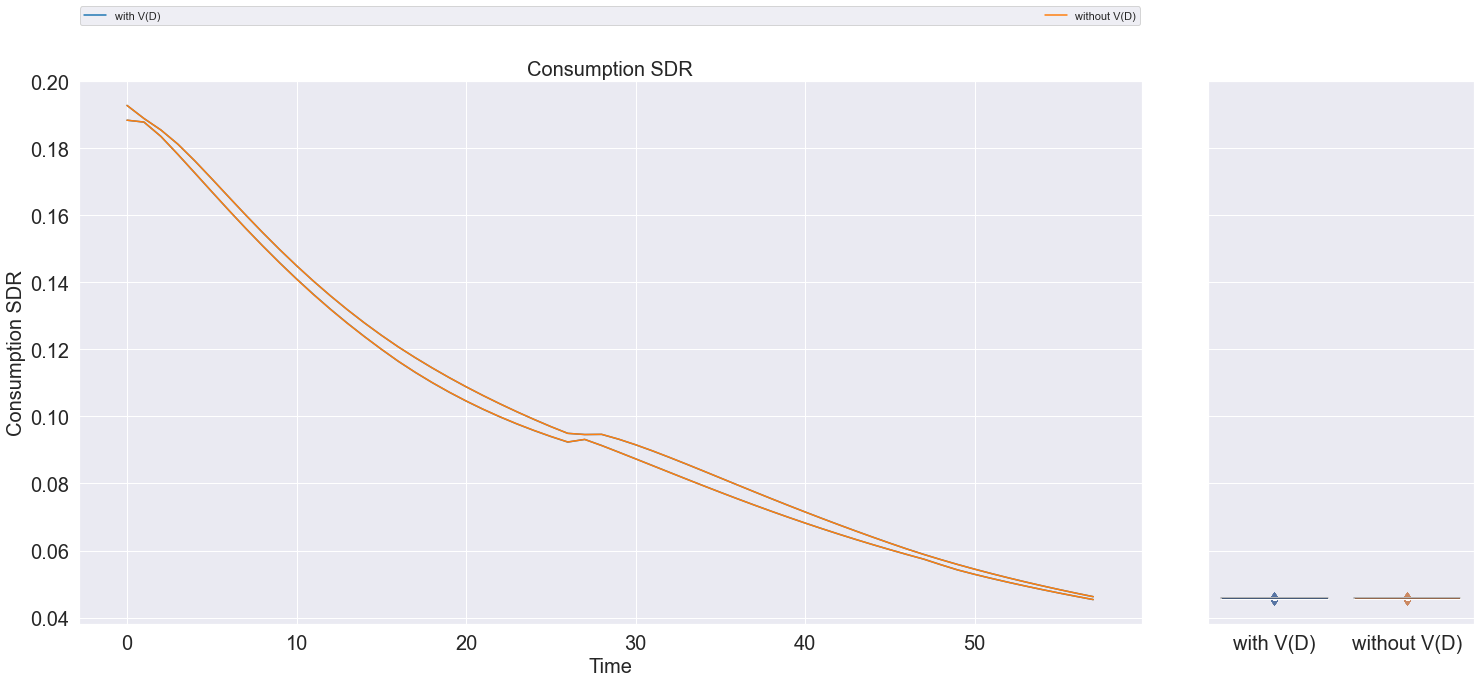

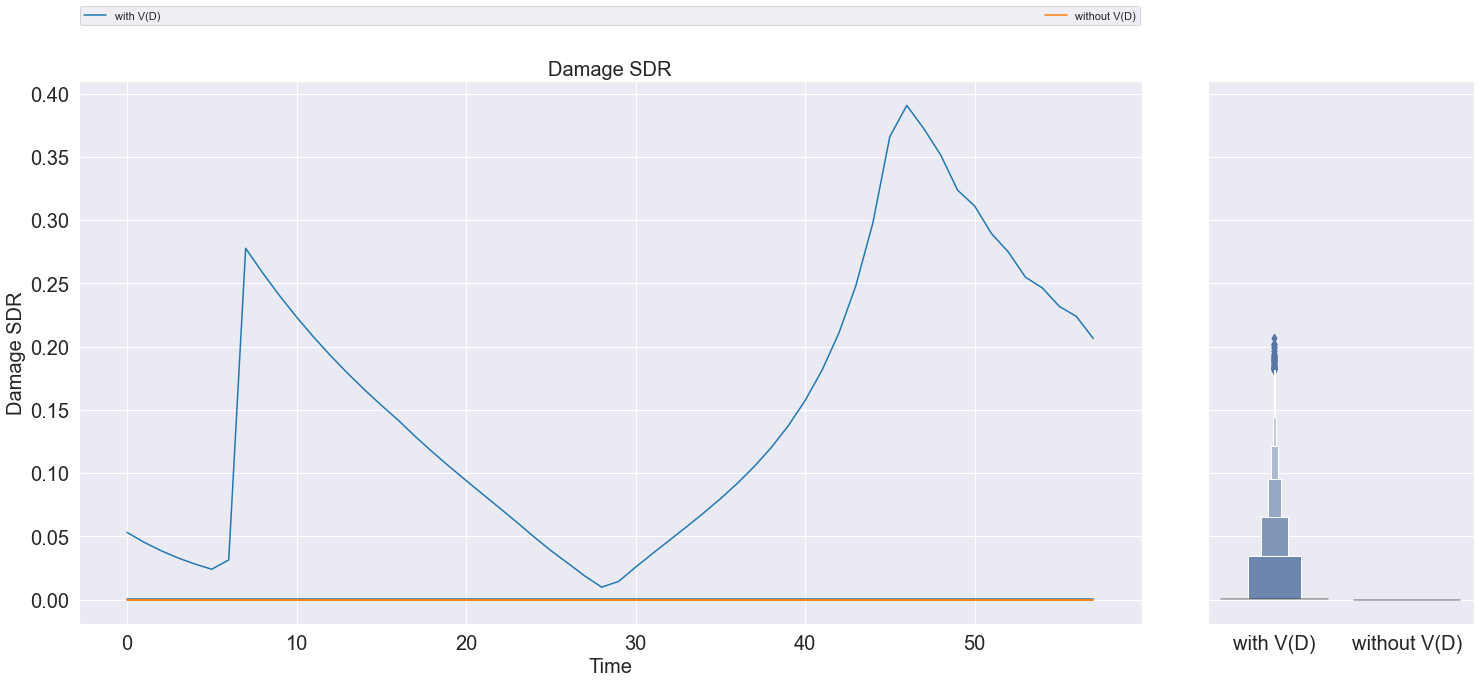

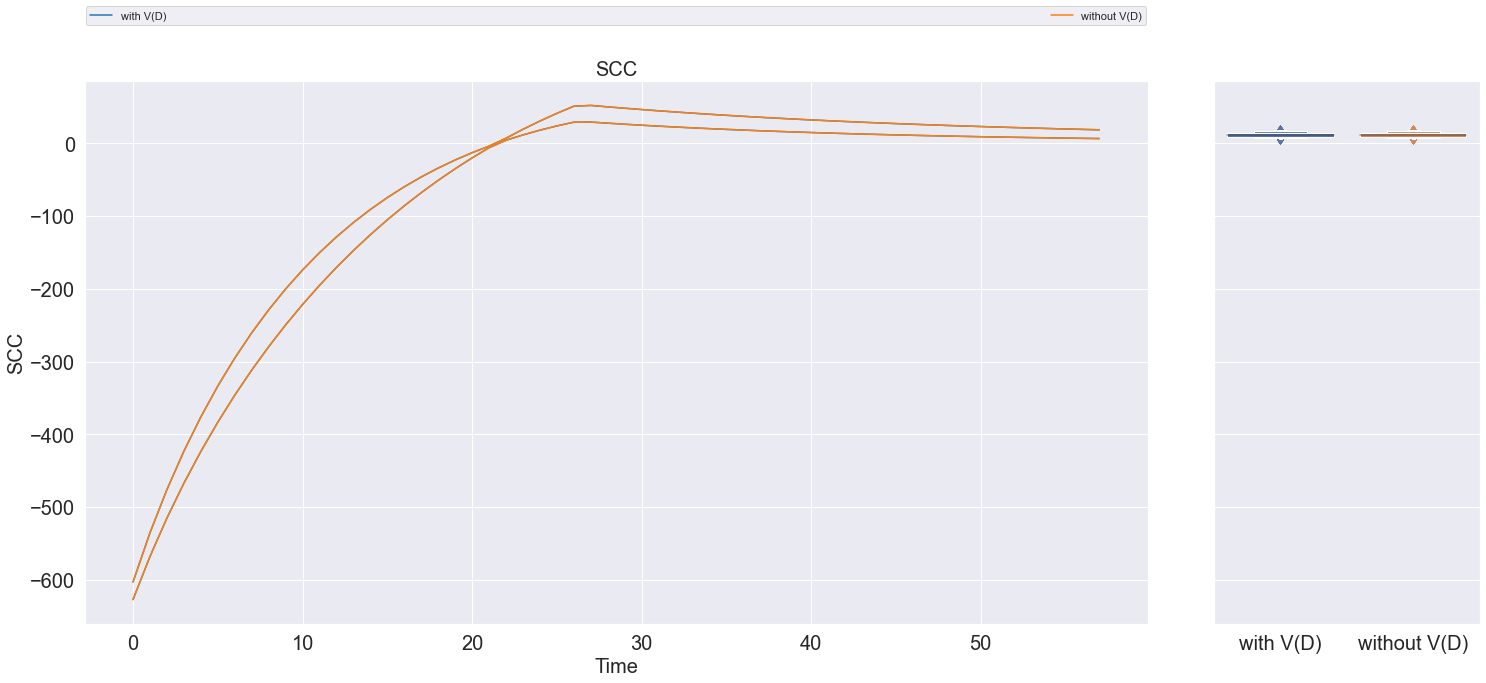

In [38]:
# Time series envelope outcome grouped by V(D) switch

for outcome in cleaned_outcome.keys():
    fig,axes=plotting.envelopes(experiments, cleaned_outcome, group_by='vd_switch',grouping_specifiers=grouping_specifiers_VD, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, legend=True)
    

    fig.set_size_inches(25, 10)
    change_fontsize(fig, fs=20)

    fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_envelope_' + str(outcome) + '.png'))
plt.show()


## Time series lines

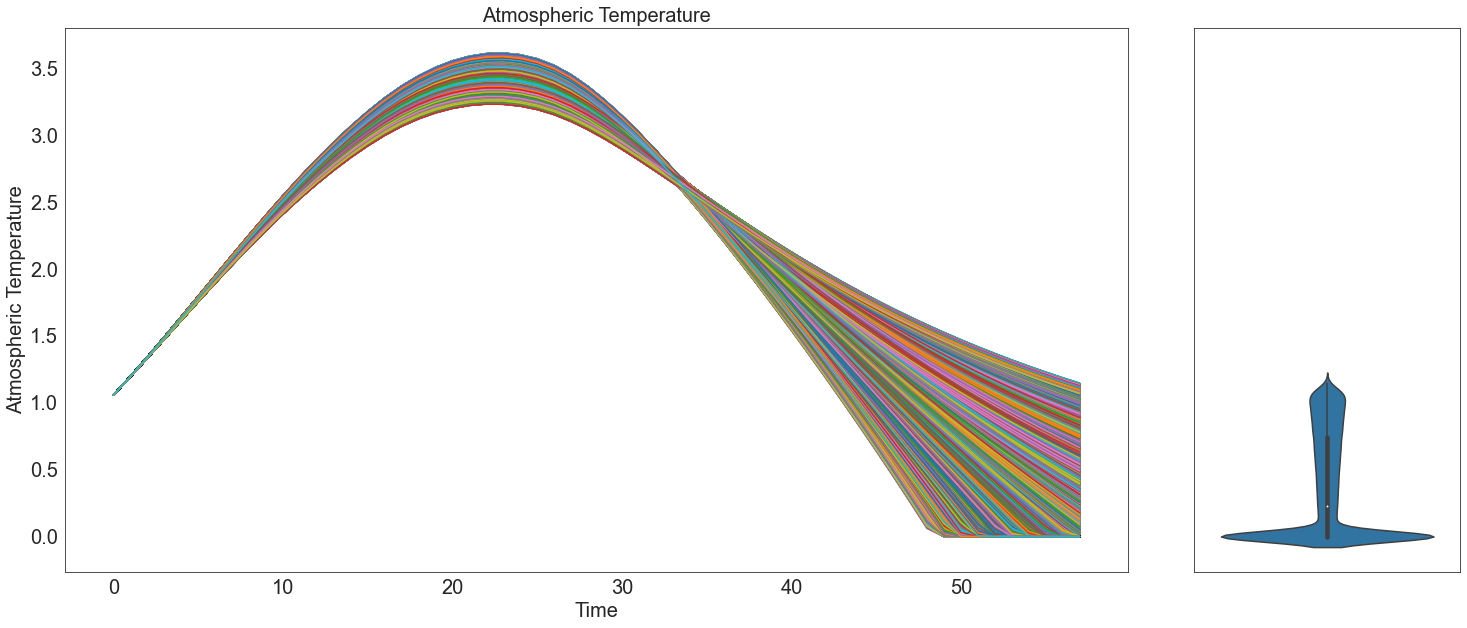

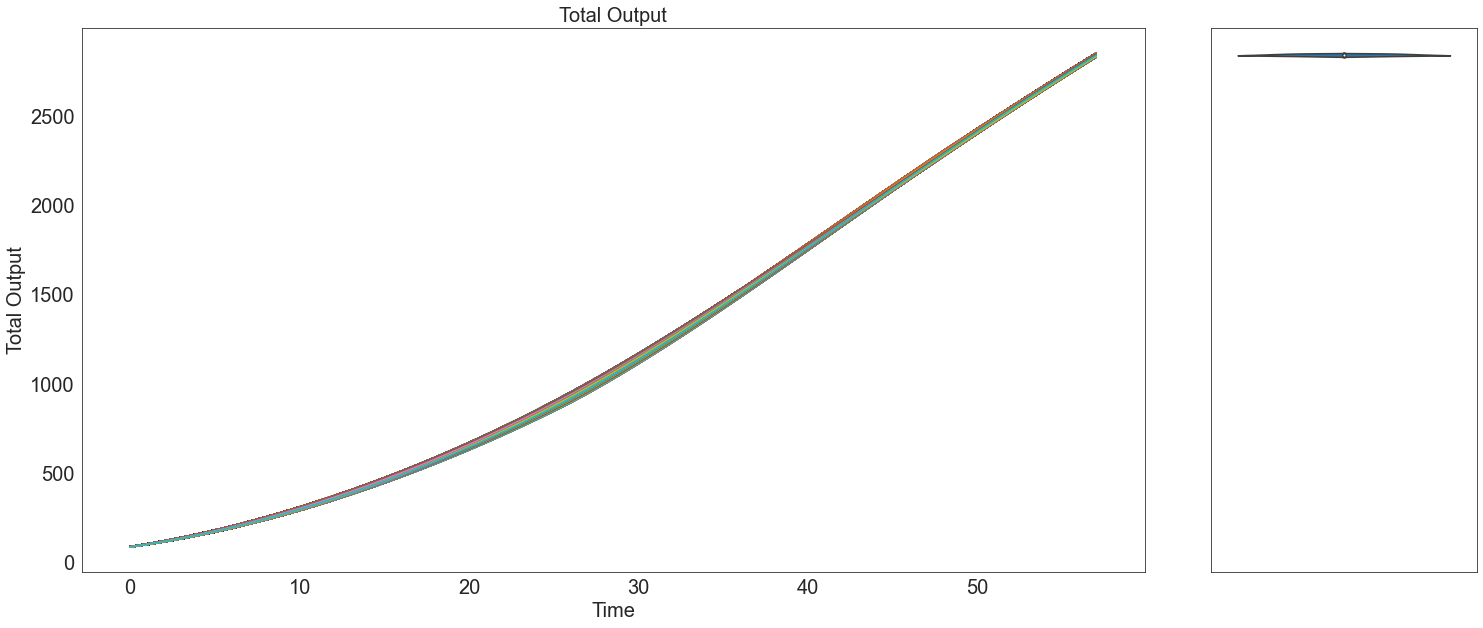

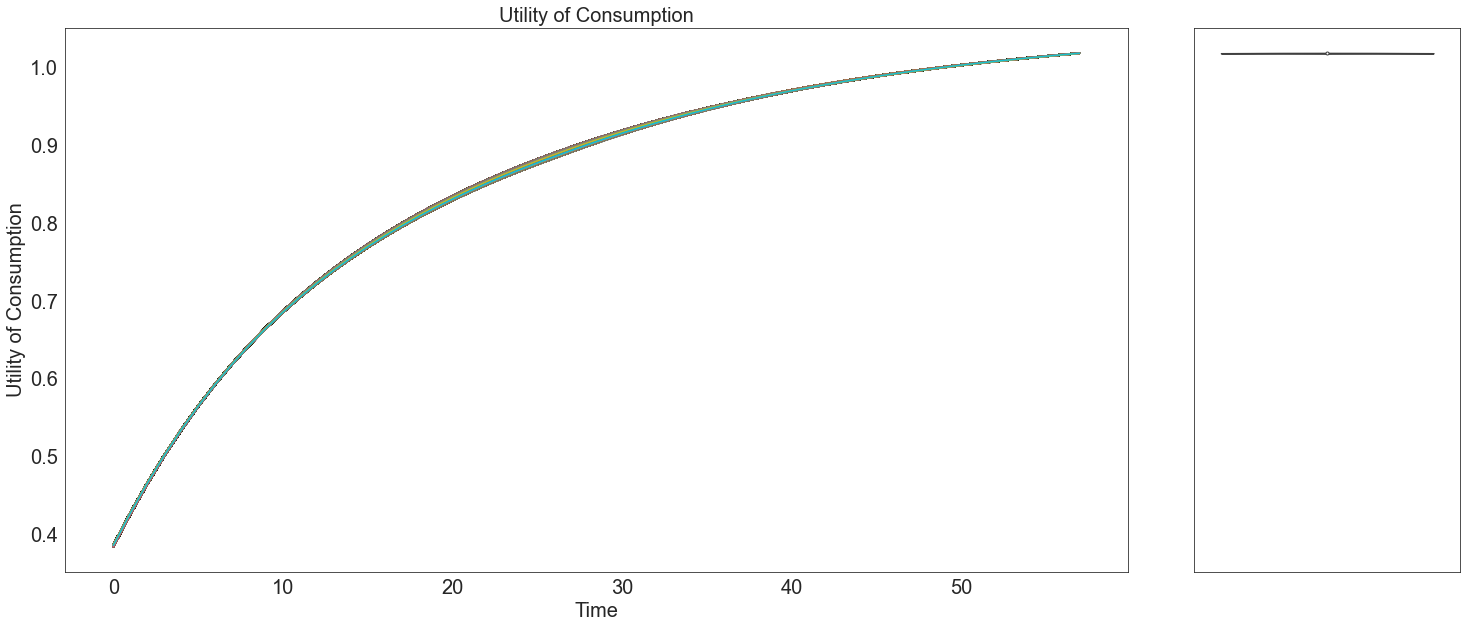

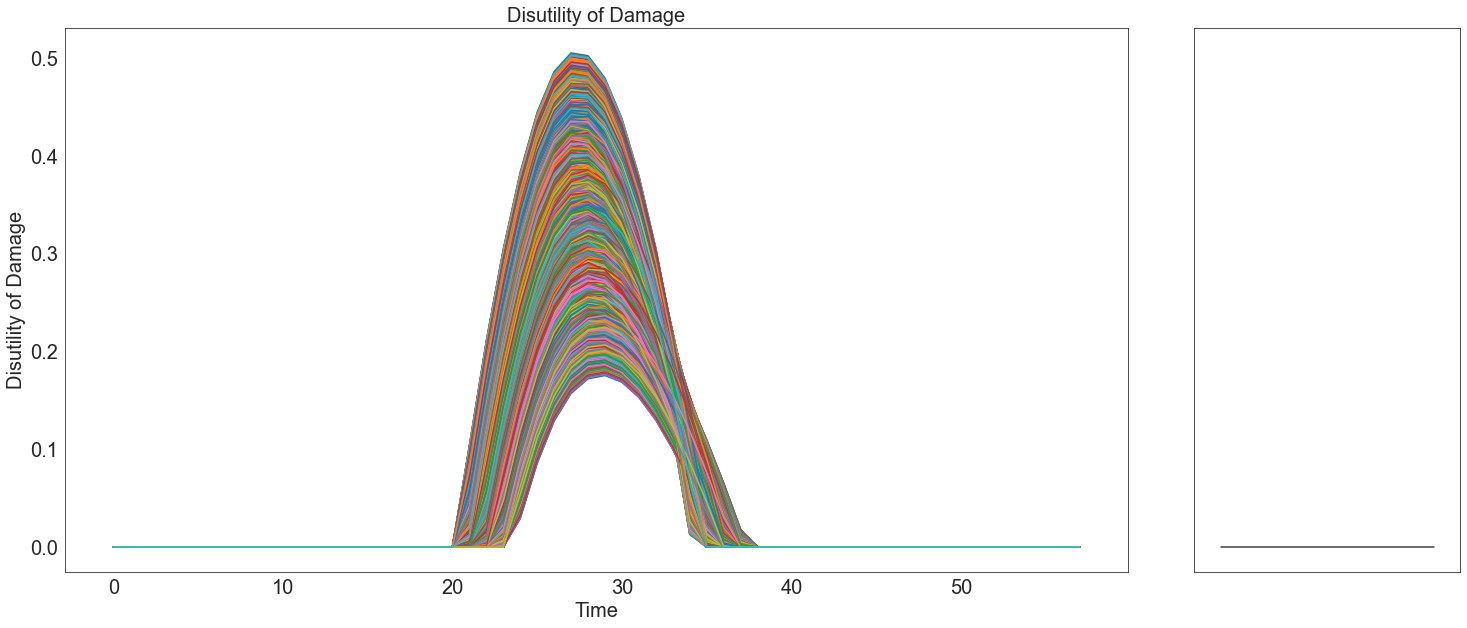

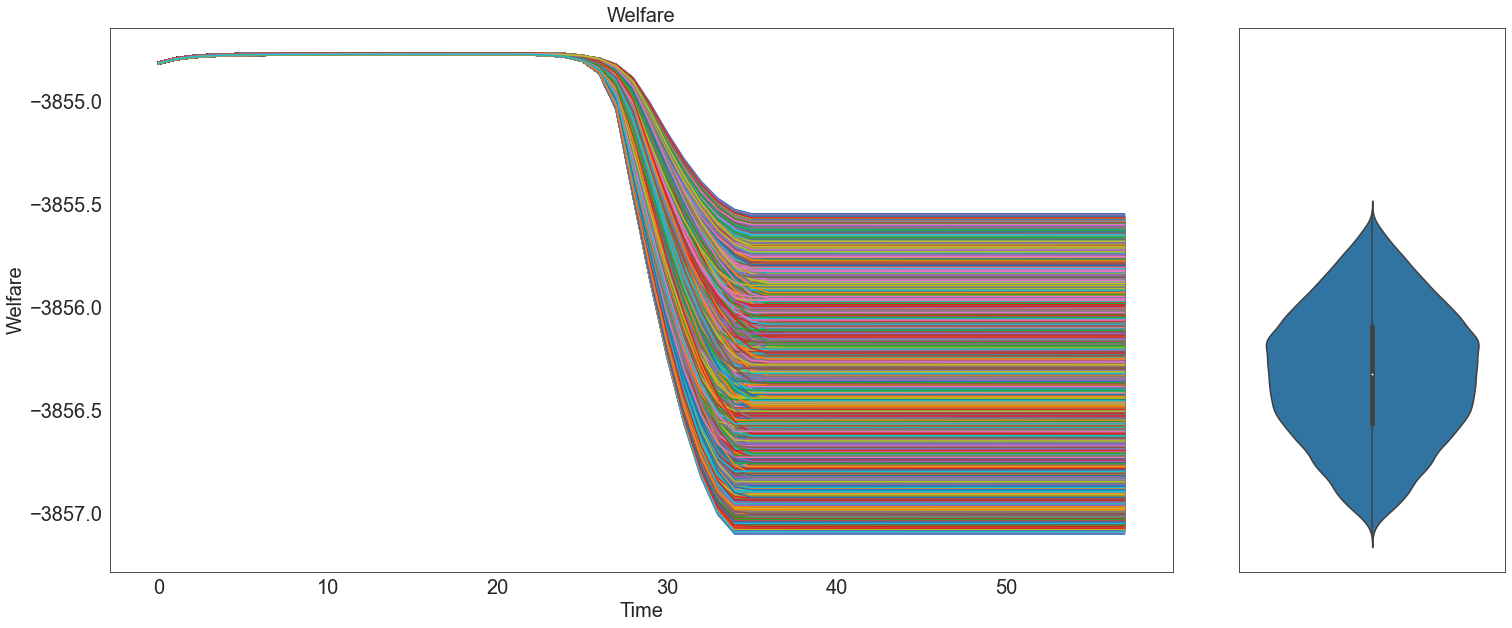

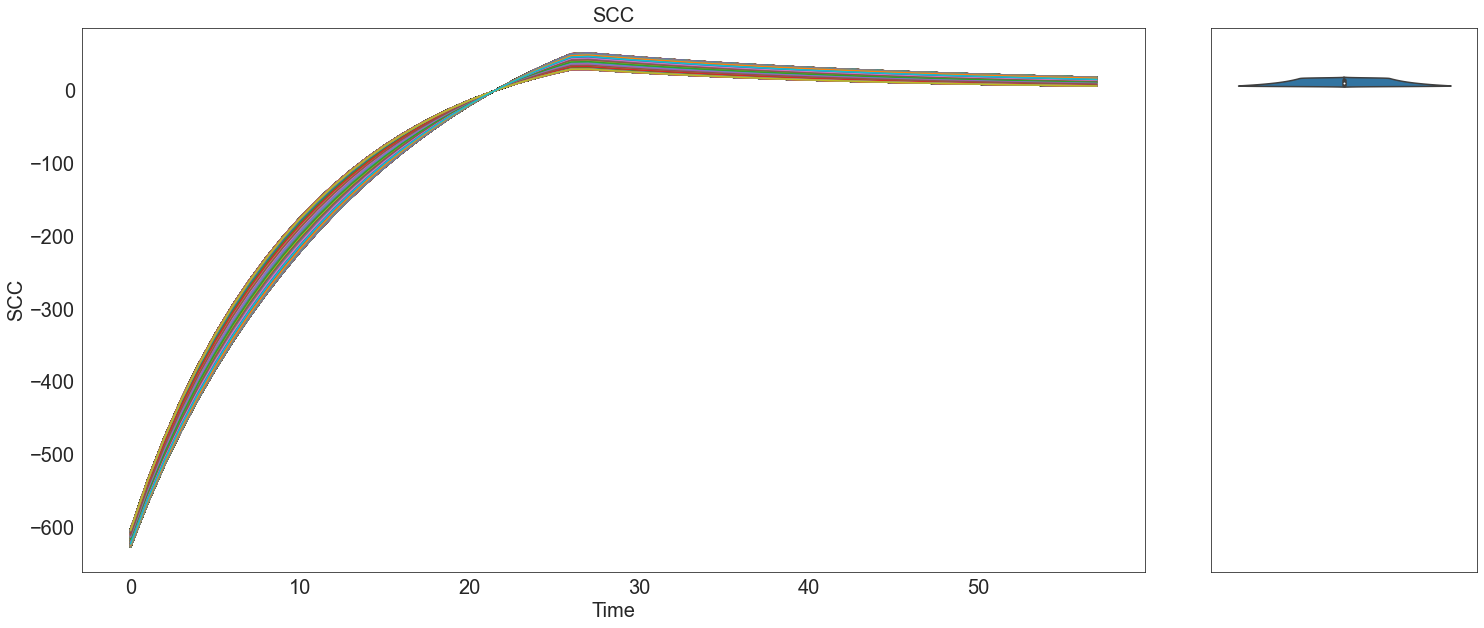

In [19]:
# Time series outcome grouped by V(D) switch

for outcome in cleaned_outcome_time.keys():
    fig,axes=plotting.lines(experiments, cleaned_outcome_time, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT, legend=True)
    

    fig.set_size_inches(25, 10)
    change_fontsize(fig, fs=20)
    # repeat_token = 2
    # fig.savefig(os.path.join(fig_path, str(run) +'_Time_grouped_envelope_' + str(outcome) + '_2.png'))
plt.show()
